## Move to folder before running!

In [3]:
%matplotlib widget
import warnings
warnings.filterwarnings('ignore')
#imports
from src.util.MetaDataGenerator import CreateRAVDESSMetadata 
from scipy import stats
import numpy as np
import plotly.express as px
import librosa.display
import soundfile
import matplotlib.pyplot as plt

SMALL_SIZE = 6
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
cm = CreateRAVDESSMetadata()
df = cm.get_metadata()
#df = pd.read_csv('datasets/RAVDESS/metadata/RAVDESS.csv')
df.head()

,filename,filepath,filesize,sample_rate,actor,actor_sex,emotion,label


#### Step 2: Inspect the data

In [30]:
# check for null values
print('Null Value Count: ', df.isnull().sum().sum())

# is everything the same sample rate? 
print('Total Unique Sample Rates: ',df['sample_rate'].nunique())

# are our files mostly short and the same size?
fig = px.scatter(df['filesize'], title='file size',width=400, height=300)
fig.update_layout(
    autosize=False,
    width=500,
    height=300,margin=dict(
        l=10,
        r=10,
        b=10,
        t=40,
        pad=4
    ))
fig.show()

Null Value Count:  0
Total Unique Sample Rates:  1


In [12]:
# We can clearly see a few outliers there
# Let's look at z-scores
import plotly.graph_objects as go
zs = np.abs(stats.zscore(df['filesize']))
outliers = df[zs > 3].copy()
outliers.sort_values(by='filesize', inplace=True, ascending=False)


#print(outliers.style.hide(['filepath', 'sample_rate'], axis=1).to_string())
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['filesize','actor_sex','emotion','label']),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[outliers.filesize,outliers.actor_sex,outliers.emotion,outliers.label],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(
    autosize=False,
    width=500,
    height=300,margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=4
    ))

fig.show()





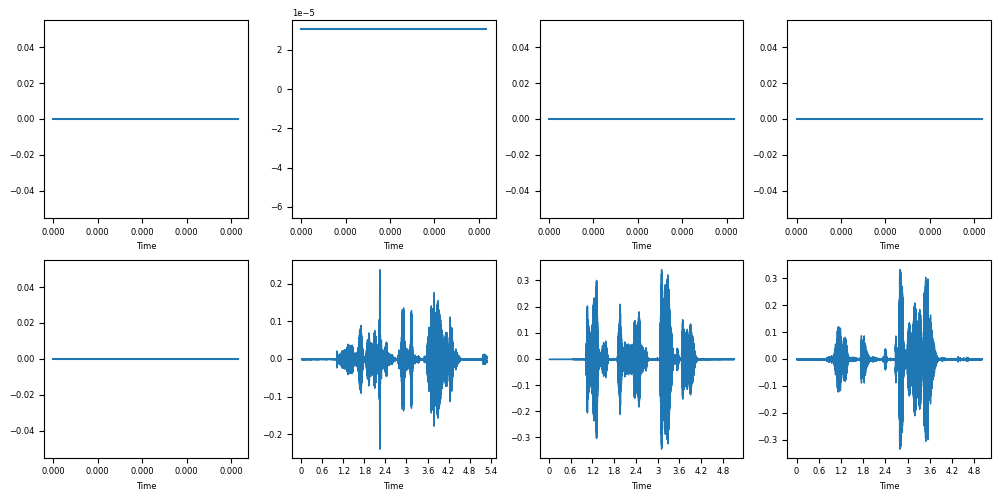

In [31]:
i = 1

fig = plt.subplots(2, 4, figsize=(10, 5))


for file in outliers['filepath']:
   
    with soundfile.SoundFile(file) as audio:
        wav = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        plt.subplot(2, 4, i)
        librosa.display.waveshow(wav, sr=sample_rate)
        i += 1


plt.tight_layout()


plt.show()

In [21]:
# So we can definitely throw out the samples with no audio showing up
# Also suspicious that
# Let's look at the sizes for the remaining files
print(outliers['filesize'].iloc[5])
print(outliers['filesize'].iloc[6])
print(outliers['filesize'].iloc[7])

# These are all on the smaller side of the outliers, let's see if they play
from IPython.display import Audio
audio_files = []
for file in [5,6,7]:
    y, sr = librosa.load(outliers['filepath'].iloc[file])
    audio_files.append(Audio(data=y, rate=sr))
audio_files[0]

554228
546582
540470


In [22]:
# So we can filter files < 600k, what arer the distributions like?
fdf = df.where(df.filesize < 600000)
#fdf['actor_sex'] = fdf['gender']
fig = px.histogram(fdf, x="actor_sex", histfunc="count", nbins=8, text_auto=True,width=400, height=300)
fig.show()

In [54]:
fdf = df.where(df.filesize < 600000)
fig = px.histogram(fdf, x="emotion", histfunc="count", nbins=8, text_auto=True,width=400, height=300)
fig.show()

In [55]:
fig = px.histogram(fdf, x="label", histfunc="count", nbins=8, text_auto=True,width=400, height=300)
fig.show()
